In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 20:35:58.215500
thunder  Sun Dec 22 20:35:58 2019
[0] GeForce GTX 1080 Ti | 50'C,  24 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 43'C,   0 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 20:36:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 35%   49C    P2    80W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 30%   45C    P2    72W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 26s 514ms/step - loss: 0.7278 - Accuracy: 0.5788 - Precision: 0.5875 - Recall: 0.6440 - F1: 0.6018 - AUC: 0.5975 - val_loss: 2.3475 - val_Accuracy: 0.0375 - val_Precision: 0.0375 - val_Recall: 0.7000 - val_F1: 0.0691 - val_AUC: 0.5805
Epoch 2/200
50/50 [==============================] - 22s 440ms/step - loss: 0.6936 - Accuracy: 0.6062 - Precision: 0.6123 - Recall: 0.6288 - F1: 0.6141 - AUC: 0.6249 - val_loss: 0.9589 - val_Accuracy: 0.2875 - val_Precision: 0.0406 - val_Recall: 0.5000 - val_F1: 0.0746 - val_AUC: 0.5980
Epoch 3/200
50/50 [==============================] - 24s 490ms/step - loss: 0.6469 - Accuracy: 0.6350 - Precision: 0.6270 - Recall: 0.6396 - F1: 0.6278 - AUC: 0.6913 - val_loss: 1.8821 - val_Accuracy: 0.0844 - val_Precision: 0.0235 - val_Recall: 0.6000 - val_F1: 0.0450 - val_AUC: 0.6764
Epoch 4/200
50/50 [==============================] - 23s 452ms/step - loss: 0.6412 - Accuracy: 0.6450 - Precision: 0.6371 - Recall: 0.70

Epoch 29/200
50/50 [==============================] - 24s 489ms/step - loss: 0.5291 - Accuracy: 0.7400 - Precision: 0.7492 - Recall: 0.7257 - F1: 0.7308 - AUC: 0.8142 - val_loss: 0.6583 - val_Accuracy: 0.6969 - val_Precision: 0.0573 - val_Recall: 0.2667 - val_F1: 0.0918 - val_AUC: 0.6419
Epoch 30/200
50/50 [==============================] - 21s 427ms/step - loss: 0.5443 - Accuracy: 0.7331 - Precision: 0.7283 - Recall: 0.7546 - F1: 0.7345 - AUC: 0.7968 - val_loss: 0.4556 - val_Accuracy: 0.6344 - val_Precision: 0.0467 - val_Recall: 0.2333 - val_F1: 0.0775 - val_AUC: 0.5441
Epoch 31/200
50/50 [==============================] - 21s 426ms/step - loss: 0.5153 - Accuracy: 0.7456 - Precision: 0.7272 - Recall: 0.7788 - F1: 0.7439 - AUC: 0.8216 - val_loss: 0.7152 - val_Accuracy: 0.5938 - val_Precision: 0.0227 - val_Recall: 0.2500 - val_F1: 0.0412 - val_AUC: 0.7168
Epoch 32/200
50/50 [==============================] - 24s 489ms/step - loss: 0.5438 - Accuracy: 0.7119 - Precision: 0.6906 - Recall: 

50/50 [==============================] - 21s 419ms/step - loss: 0.5020 - Accuracy: 0.7594 - Precision: 0.7384 - Recall: 0.7973 - F1: 0.7584 - AUC: 0.8419 - val_loss: 0.4478 - val_Accuracy: 0.7406 - val_Precision: 0.0443 - val_Recall: 0.3000 - val_F1: 0.0765 - val_AUC: 0.6906
Epoch 58/200
50/50 [==============================] - 21s 421ms/step - loss: 0.5268 - Accuracy: 0.7406 - Precision: 0.7355 - Recall: 0.7702 - F1: 0.7457 - AUC: 0.8131 - val_loss: 0.6638 - val_Accuracy: 0.6938 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.5645
Epoch 59/200
50/50 [==============================] - 25s 493ms/step - loss: 0.5208 - Accuracy: 0.7425 - Precision: 0.7527 - Recall: 0.7689 - F1: 0.7550 - AUC: 0.8208 - val_loss: 0.4802 - val_Accuracy: 0.7000 - val_Precision: 0.0200 - val_Recall: 0.2000 - val_F1: 0.0364 - val_AUC: 0.7976
Epoch 60/200
50/50 [==============================] - 21s 420ms/step - loss: 0.5124 - Accuracy: 0.7450 - Precision: 0.7410 - Recall: 0.7729 - F1: 

50/50 [==============================] - 22s 432ms/step - loss: 0.4987 - Accuracy: 0.7613 - Precision: 0.7586 - Recall: 0.7878 - F1: 0.7671 - AUC: 0.8420 - val_loss: 0.6881 - val_Accuracy: 0.7219 - val_Precision: 0.0422 - val_Recall: 0.2667 - val_F1: 0.0697 - val_AUC: 0.7702
Epoch 86/200
50/50 [==============================] - 24s 479ms/step - loss: 0.4990 - Accuracy: 0.7631 - Precision: 0.7641 - Recall: 0.7878 - F1: 0.7706 - AUC: 0.8413 - val_loss: 0.4416 - val_Accuracy: 0.7156 - val_Precision: 0.0416 - val_Recall: 0.2500 - val_F1: 0.0675 - val_AUC: 0.6853
Epoch 87/200
50/50 [==============================] - 21s 414ms/step - loss: 0.5101 - Accuracy: 0.7531 - Precision: 0.7378 - Recall: 0.7971 - F1: 0.7610 - AUC: 0.8349 - val_loss: 0.5632 - val_Accuracy: 0.7000 - val_Precision: 0.0612 - val_Recall: 0.4833 - val_F1: 0.1071 - val_AUC: 0.6725
Epoch 88/200
50/50 [==============================] - 21s 425ms/step - loss: 0.5030 - Accuracy: 0.7544 - Precision: 0.7338 - Recall: 0.7937 - F1: 

50/50 [==============================] - 25s 491ms/step - loss: 0.5053 - Accuracy: 0.7538 - Precision: 0.7507 - Recall: 0.7836 - F1: 0.7586 - AUC: 0.8369 - val_loss: 0.5263 - val_Accuracy: 0.6875 - val_Precision: 0.0703 - val_Recall: 0.4500 - val_F1: 0.1214 - val_AUC: 0.7585
Epoch 114/200
50/50 [==============================] - 22s 431ms/step - loss: 0.5142 - Accuracy: 0.7406 - Precision: 0.7282 - Recall: 0.7754 - F1: 0.7431 - AUC: 0.8264 - val_loss: 0.5053 - val_Accuracy: 0.7563 - val_Precision: 0.0494 - val_Recall: 0.3333 - val_F1: 0.0811 - val_AUC: 0.7201
Epoch 115/200
50/50 [==============================] - 24s 481ms/step - loss: 0.5118 - Accuracy: 0.7387 - Precision: 0.7118 - Recall: 0.7884 - F1: 0.7394 - AUC: 0.8282 - val_loss: 0.5278 - val_Accuracy: 0.7281 - val_Precision: 0.0643 - val_Recall: 0.5500 - val_F1: 0.1142 - val_AUC: 0.7433
Epoch 116/200
50/50 [==============================] - 22s 431ms/step - loss: 0.5179 - Accuracy: 0.7525 - Precision: 0.7463 - Recall: 0.7715 - F

50/50 [==============================] - 22s 432ms/step - loss: 0.4914 - Accuracy: 0.7594 - Precision: 0.7639 - Recall: 0.7904 - F1: 0.7693 - AUC: 0.8491 - val_loss: 0.5137 - val_Accuracy: 0.6875 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.5714
Epoch 142/200
50/50 [==============================] - 24s 484ms/step - loss: 0.4962 - Accuracy: 0.7656 - Precision: 0.7610 - Recall: 0.7847 - F1: 0.7668 - AUC: 0.8461 - val_loss: 0.4741 - val_Accuracy: 0.7063 - val_Precision: 0.0404 - val_Recall: 0.3500 - val_F1: 0.0715 - val_AUC: 0.6374
Epoch 143/200
50/50 [==============================] - 21s 425ms/step - loss: 0.5136 - Accuracy: 0.7462 - Precision: 0.7183 - Recall: 0.7898 - F1: 0.7454 - AUC: 0.8261 - val_loss: 0.4772 - val_Accuracy: 0.7563 - val_Precision: 0.0244 - val_Recall: 0.2000 - val_F1: 0.0429 - val_AUC: 0.6244
Epoch 144/200
50/50 [==============================] - 21s 426ms/step - loss: 0.5031 - Accuracy: 0.7544 - Precision: 0.7470 - Recall: 0.7861 - F

50/50 [==============================] - 25s 492ms/step - loss: 0.5062 - Accuracy: 0.7538 - Precision: 0.7401 - Recall: 0.7859 - F1: 0.7559 - AUC: 0.8362 - val_loss: 0.5638 - val_Accuracy: 0.6719 - val_Precision: 0.0523 - val_Recall: 0.3500 - val_F1: 0.0889 - val_AUC: 0.5910
Epoch 170/200
50/50 [==============================] - 21s 414ms/step - loss: 0.4910 - Accuracy: 0.7738 - Precision: 0.7657 - Recall: 0.8028 - F1: 0.7775 - AUC: 0.8512 - val_loss: 0.4378 - val_Accuracy: 0.6906 - val_Precision: 0.0488 - val_Recall: 0.4500 - val_F1: 0.0873 - val_AUC: 0.7001
Epoch 171/200
50/50 [==============================] - 21s 419ms/step - loss: 0.4997 - Accuracy: 0.7631 - Precision: 0.7320 - Recall: 0.8088 - F1: 0.7623 - AUC: 0.8424 - val_loss: 0.4983 - val_Accuracy: 0.7219 - val_Precision: 0.0234 - val_Recall: 0.2000 - val_F1: 0.0417 - val_AUC: 0.5592
Epoch 172/200
50/50 [==============================] - 25s 506ms/step - loss: 0.4984 - Accuracy: 0.7669 - Precision: 0.7456 - Recall: 0.8096 - F

50/50 [==============================] - 21s 411ms/step - loss: 0.4744 - Accuracy: 0.7788 - Precision: 0.7586 - Recall: 0.8115 - F1: 0.7782 - AUC: 0.8686 - val_loss: 0.6586 - val_Accuracy: 0.7031 - val_Precision: 0.0551 - val_Recall: 0.3600 - val_F1: 0.0926 - val_AUC: 0.6790
Epoch 198/200
50/50 [==============================] - 25s 502ms/step - loss: 0.5098 - Accuracy: 0.7494 - Precision: 0.7497 - Recall: 0.7687 - F1: 0.7521 - AUC: 0.8324 - val_loss: 0.6234 - val_Accuracy: 0.7094 - val_Precision: 0.0446 - val_Recall: 0.3000 - val_F1: 0.0759 - val_AUC: 0.6452
Epoch 199/200
50/50 [==============================] - 21s 423ms/step - loss: 0.5066 - Accuracy: 0.7638 - Precision: 0.7698 - Recall: 0.7760 - F1: 0.7672 - AUC: 0.8379 - val_loss: 0.5292 - val_Accuracy: 0.6875 - val_Precision: 0.0489 - val_Recall: 0.3000 - val_F1: 0.0783 - val_AUC: 0.5775
Epoch 200/200
50/50 [==============================] - 21s 423ms/step - loss: 0.5125 - Accuracy: 0.7556 - Precision: 0.7386 - Recall: 0.8019 - F

In [21]:
print("Time taken:",end-start)

Time taken: 4497.69629740715


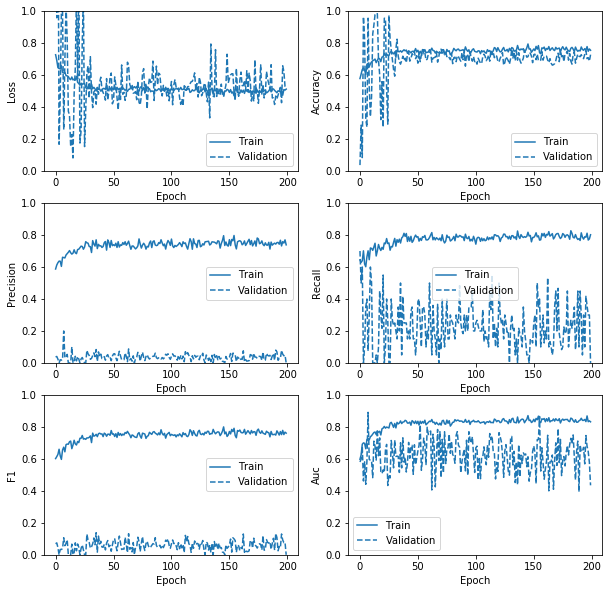

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [24]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight={0:0.5,1:1.5},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 413ms/step - loss: 0.3666 - Accuracy: 0.5938 - Precision: 0.1634 - Recall: 0.8153 - F1: 0.2616 - AUC: 0.8541 - val_loss: 0.5646 - val_Accuracy: 0.6750 - val_Precision: 0.0814 - val_Recall: 0.6167 - val_F1: 0.1356 - val_AUC: 0.6536
Epoch 2/200
50/50 [==============================] - 23s 453ms/step - loss: 0.3589 - Accuracy: 0.6150 - Precision: 0.1883 - Recall: 0.8917 - F1: 0.3006 - AUC: 0.8452 - val_loss: 0.7121 - val_Accuracy: 0.6687 - val_Precision: 0.0178 - val_Recall: 0.1333 - val_F1: 0.0292 - val_AUC: 0.5382
Epoch 3/200
50/50 [==============================] - 19s 385ms/step - loss: 0.3613 - Accuracy: 0.6037 - Precision: 0.1614 - Recall: 0.8163 - F1: 0.2602 - AUC: 0.8251 - val_loss: 0.7189 - val_Accuracy: 0.6500 - val_Precision: 0.0344 - val_Recall: 0.2000 - val_F1: 0.0560 - val_AUC: 0.6764
Epoch 4/200
50/50 [==============================] - 20s 396ms/step - loss: 0.3440 - Accuracy: 0.6513 - Precision: 0.2013 - Recall: 0.89

50/50 [==============================] - 21s 411ms/step - loss: 0.2657 - Accuracy: 0.8225 - Precision: 0.2620 - Recall: 0.5540 - F1: 0.3321 - AUC: 0.8245 - val_loss: 0.3908 - val_Accuracy: 0.7812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4600
Epoch 30/200
50/50 [==============================] - 24s 478ms/step - loss: 0.2687 - Accuracy: 0.8288 - Precision: 0.3035 - Recall: 0.5925 - F1: 0.3685 - AUC: 0.8367 - val_loss: 0.4700 - val_Accuracy: 0.7969 - val_Precision: 0.0200 - val_Recall: 0.0500 - val_F1: 0.0286 - val_AUC: 0.5563
Epoch 31/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2649 - Accuracy: 0.8381 - Precision: 0.2946 - Recall: 0.5027 - F1: 0.3464 - AUC: 0.8342 - val_loss: 0.4370 - val_Accuracy: 0.8156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4711
Epoch 32/200
50/50 [==============================] - 20s 397ms/step - loss: 0.2565 - Accuracy: 0.8419 - Precision: 0.3426

50/50 [==============================] - 20s 392ms/step - loss: 0.2401 - Accuracy: 0.8788 - Precision: 0.3170 - Recall: 0.3800 - F1: 0.3144 - AUC: 0.8318 - val_loss: 0.4777 - val_Accuracy: 0.8687 - val_Precision: 0.0676 - val_Recall: 0.2500 - val_F1: 0.1056 - val_AUC: 0.6750
Epoch 58/200
50/50 [==============================] - 20s 395ms/step - loss: 0.2384 - Accuracy: 0.8844 - Precision: 0.3667 - Recall: 0.3580 - F1: 0.3223 - AUC: 0.8517 - val_loss: 0.3080 - val_Accuracy: 0.8875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4698
Epoch 59/200
50/50 [==============================] - 24s 480ms/step - loss: 0.2476 - Accuracy: 0.8869 - Precision: 0.3956 - Recall: 0.4343 - F1: 0.3839 - AUC: 0.8319 - val_loss: 0.3471 - val_Accuracy: 0.9156 - val_Precision: 0.0500 - val_Recall: 0.0333 - val_F1: 0.0400 - val_AUC: 0.5488
Epoch 60/200
50/50 [==============================] - 20s 392ms/step - loss: 0.2490 - Accuracy: 0.8781 - Precision: 0.3293 - Recall: 0

50/50 [==============================] - 19s 384ms/step - loss: 0.2455 - Accuracy: 0.8919 - Precision: 0.4137 - Recall: 0.3620 - F1: 0.3435 - AUC: 0.8381 - val_loss: 0.3773 - val_Accuracy: 0.9125 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6420
Epoch 86/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2104 - Accuracy: 0.9119 - Precision: 0.4574 - Recall: 0.4220 - F1: 0.3863 - AUC: 0.8692 - val_loss: 0.2691 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6790
Epoch 87/200
50/50 [==============================] - 24s 472ms/step - loss: 0.2271 - Accuracy: 0.9075 - Precision: 0.5067 - Recall: 0.4309 - F1: 0.4077 - AUC: 0.8664 - val_loss: 0.2553 - val_Accuracy: 0.9281 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6473
Epoch 88/200
50/50 [==============================] - 19s 390ms/step - loss: 0.2363 - Accuracy: 0.9089 - Precision: 0.5200 - Recall: 0

Epoch 113/200
50/50 [==============================] - 24s 476ms/step - loss: 0.2491 - Accuracy: 0.9069 - Precision: 0.4680 - Recall: 0.3343 - F1: 0.3553 - AUC: 0.8446 - val_loss: 0.3391 - val_Accuracy: 0.9438 - val_Precision: 0.2000 - val_Recall: 0.0833 - val_F1: 0.1167 - val_AUC: 0.5669
Epoch 114/200
50/50 [==============================] - 20s 402ms/step - loss: 0.2540 - Accuracy: 0.8944 - Precision: 0.3863 - Recall: 0.3430 - F1: 0.3345 - AUC: 0.8216 - val_loss: 0.3540 - val_Accuracy: 0.9375 - val_Precision: 0.1333 - val_Recall: 0.1000 - val_F1: 0.1067 - val_AUC: 0.6150
Epoch 115/200
50/50 [==============================] - 24s 481ms/step - loss: 0.2250 - Accuracy: 0.9106 - Precision: 0.4533 - Recall: 0.4135 - F1: 0.3973 - AUC: 0.8611 - val_loss: 0.3347 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6634
Epoch 116/200
50/50 [==============================] - 19s 383ms/step - loss: 0.2237 - Accuracy: 0.8988 - Precision: 0

Epoch 141/200
50/50 [==============================] - 24s 484ms/step - loss: 0.2269 - Accuracy: 0.9069 - Precision: 0.3377 - Recall: 0.2837 - F1: 0.2876 - AUC: 0.8396 - val_loss: 0.2834 - val_Accuracy: 0.9438 - val_Precision: 0.1500 - val_Recall: 0.1000 - val_F1: 0.1167 - val_AUC: 0.7416
Epoch 142/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2343 - Accuracy: 0.9031 - Precision: 0.4370 - Recall: 0.3170 - F1: 0.3330 - AUC: 0.8657 - val_loss: 0.3649 - val_Accuracy: 0.9344 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.6044
Epoch 143/200
50/50 [==============================] - 20s 406ms/step - loss: 0.2314 - Accuracy: 0.9087 - Precision: 0.4490 - Recall: 0.2877 - F1: 0.3299 - AUC: 0.8510 - val_loss: 0.2665 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6088
Epoch 144/200
50/50 [==============================] - 24s 482ms/step - loss: 0.2263 - Accuracy: 0.9121 - Precision: 0

50/50 [==============================] - 21s 412ms/step - loss: 0.2357 - Accuracy: 0.9019 - Precision: 0.3267 - Recall: 0.2647 - F1: 0.2789 - AUC: 0.8146 - val_loss: 0.2411 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4652
Epoch 169/200
50/50 [==============================] - 24s 473ms/step - loss: 0.2121 - Accuracy: 0.9169 - Precision: 0.5423 - Recall: 0.4471 - F1: 0.4415 - AUC: 0.8781 - val_loss: 0.1860 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5253
Epoch 170/200
50/50 [==============================] - 20s 397ms/step - loss: 0.2445 - Accuracy: 0.9062 - Precision: 0.3427 - Recall: 0.2486 - F1: 0.2677 - AUC: 0.8384 - val_loss: 0.2498 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5560
Epoch 171/200
50/50 [==============================] - 21s 412ms/step - loss: 0.2252 - Accuracy: 0.9100 - Pr

50/50 [==============================] - 24s 472ms/step - loss: 0.2232 - Accuracy: 0.9075 - Precision: 0.3750 - Recall: 0.2900 - F1: 0.2987 - AUC: 0.8604 - val_loss: 0.2195 - val_Accuracy: 0.9500 - val_Precision: 0.0500 - val_Recall: 0.0333 - val_F1: 0.0400 - val_AUC: 0.5385
Epoch 196/200
50/50 [==============================] - 20s 408ms/step - loss: 0.2237 - Accuracy: 0.9094 - Precision: 0.3847 - Recall: 0.3814 - F1: 0.3475 - AUC: 0.8377 - val_loss: 0.2363 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6652
Epoch 197/200
50/50 [==============================] - 24s 476ms/step - loss: 0.2306 - Accuracy: 0.9006 - Precision: 0.4160 - Recall: 0.3421 - F1: 0.3538 - AUC: 0.8663 - val_loss: 0.2460 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6401
Epoch 198/200
50/50 [==============================] - 20s 393ms/step - loss: 0.2412 - Accuracy: 0.9056 - Precision: 0.4

In [25]:
print("Time taken:",end-start)

Time taken: 4248.7924563884735


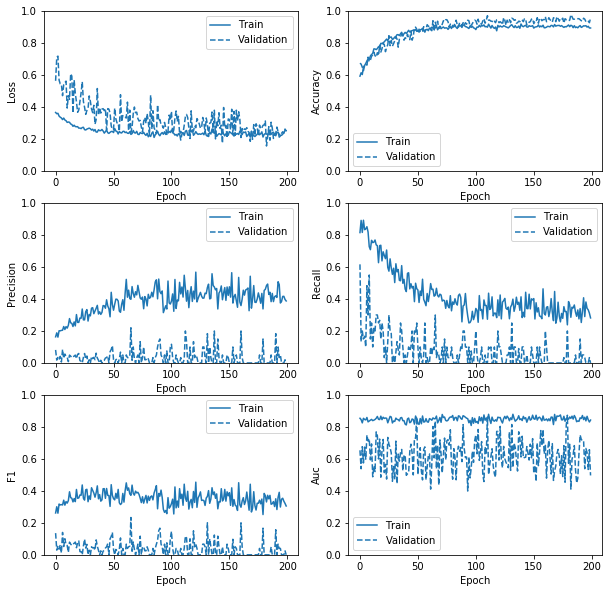

In [26]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [27]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight={0:0.3,1:1.8},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 411ms/step - loss: 0.1402 - Accuracy: 0.9381 - Precision: 0.2817 - Recall: 0.3633 - F1: 0.2940 - AUC: 0.8737 - val_loss: 0.2953 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5301
Epoch 2/200
50/50 [==============================] - 20s 409ms/step - loss: 0.1390 - Accuracy: 0.9306 - Precision: 0.2183 - Recall: 0.2800 - F1: 0.2228 - AUC: 0.8435 - val_loss: 0.2849 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4090
Epoch 3/200
50/50 [==============================] - 24s 474ms/step - loss: 0.1367 - Accuracy: 0.9237 - Precision: 0.2783 - Recall: 0.3207 - F1: 0.2555 - AUC: 0.8771 - val_loss: 0.2799 - val_Accuracy: 0.9312 - val_Precision: 0.0333 - val_Recall: 0.0500 - val_F1: 0.0400 - val_AUC: 0.6723
Epoch 4/200
50/50 [==============================] - 20s 401ms/step - loss: 0.1458 - Accuracy: 0.9244 - Precisio

Epoch 29/200
50/50 [==============================] - 23s 461ms/step - loss: 0.1447 - Accuracy: 0.9337 - Precision: 0.2933 - Recall: 0.2690 - F1: 0.2636 - AUC: 0.8514 - val_loss: 0.2202 - val_Accuracy: 0.9625 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.6927
Epoch 30/200
50/50 [==============================] - 20s 404ms/step - loss: 0.1605 - Accuracy: 0.9256 - Precision: 0.2923 - Recall: 0.3103 - F1: 0.2722 - AUC: 0.8315 - val_loss: 0.2304 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5935
Epoch 31/200
50/50 [==============================] - 24s 470ms/step - loss: 0.1518 - Accuracy: 0.9281 - Precision: 0.3517 - Recall: 0.2936 - F1: 0.2957 - AUC: 0.8707 - val_loss: 0.2008 - val_Accuracy: 0.9469 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.6378
Epoch 32/200
50/50 [==============================] - 20s 396ms/step - loss: 0.1620 - Accuracy: 0.9319 - Precision: 0.350

Epoch 57/200
50/50 [==============================] - 22s 447ms/step - loss: 0.1444 - Accuracy: 0.9356 - Precision: 0.3613 - Recall: 0.3340 - F1: 0.3162 - AUC: 0.8857 - val_loss: 0.1882 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6404
Epoch 58/200
50/50 [==============================] - 20s 409ms/step - loss: 0.1250 - Accuracy: 0.9312 - Precision: 0.2833 - Recall: 0.3683 - F1: 0.2922 - AUC: 0.8767 - val_loss: 0.2514 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6713
Epoch 59/200
50/50 [==============================] - 20s 410ms/step - loss: 0.1454 - Accuracy: 0.9325 - Precision: 0.2567 - Recall: 0.2633 - F1: 0.2428 - AUC: 0.8380 - val_loss: 0.2751 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6165
Epoch 60/200
50/50 [==============================] - 23s 459ms/step - loss: 0.1483 - Accuracy: 0

50/50 [==============================] - 20s 407ms/step - loss: 0.1525 - Accuracy: 0.9350 - Precision: 0.2733 - Recall: 0.2220 - F1: 0.2207 - AUC: 0.8311 - val_loss: 0.1986 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7125
Epoch 85/200
50/50 [==============================] - 21s 414ms/step - loss: 0.1489 - Accuracy: 0.9325 - Precision: 0.3217 - Recall: 0.3667 - F1: 0.3075 - AUC: 0.8566 - val_loss: 0.3008 - val_Accuracy: 0.9312 - val_Precision: 0.1333 - val_Recall: 0.1500 - val_F1: 0.1400 - val_AUC: 0.7459
Epoch 86/200
50/50 [==============================] - 22s 437ms/step - loss: 0.1534 - Accuracy: 0.9269 - Precision: 0.2700 - Recall: 0.3167 - F1: 0.2574 - AUC: 0.8578 - val_loss: 0.3389 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6676
Epoch 87/200
50/50 [==============================] - 20s 405ms/step - loss: 0.1396 - Accuracy: 0.9337 - Precision: 0.2767

Epoch 112/200
50/50 [==============================] - 21s 417ms/step - loss: 0.1628 - Accuracy: 0.9381 - Precision: 0.3567 - Recall: 0.3083 - F1: 0.2907 - AUC: 0.8417 - val_loss: 0.2768 - val_Accuracy: 0.9563 - val_Precision: 0.2000 - val_Recall: 0.1500 - val_F1: 0.1667 - val_AUC: 0.6132
Epoch 113/200
50/50 [==============================] - 19s 381ms/step - loss: 0.1287 - Accuracy: 0.9350 - Precision: 0.2517 - Recall: 0.3067 - F1: 0.2597 - AUC: 0.8612 - val_loss: 0.2227 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7254
Epoch 114/200
50/50 [==============================] - 20s 395ms/step - loss: 0.1381 - Accuracy: 0.9375 - Precision: 0.2181 - Recall: 0.2323 - F1: 0.2014 - AUC: 0.8452 - val_loss: 0.4387 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5595
Epoch 115/200
50/50 [==============================] - 21s 415ms/step - loss: 0.1232 - Accuracy: 0.9394 - 

50/50 [==============================] - 19s 387ms/step - loss: 0.1371 - Accuracy: 0.9300 - Precision: 0.2890 - Recall: 0.3267 - F1: 0.2794 - AUC: 0.8758 - val_loss: 0.3086 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6184
Epoch 140/200
50/50 [==============================] - 19s 370ms/step - loss: 0.1396 - Accuracy: 0.9325 - Precision: 0.2250 - Recall: 0.2357 - F1: 0.2108 - AUC: 0.8473 - val_loss: 0.2975 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5374
Epoch 141/200
50/50 [==============================] - 19s 376ms/step - loss: 0.1434 - Accuracy: 0.9369 - Precision: 0.2200 - Recall: 0.2637 - F1: 0.2173 - AUC: 0.8647 - val_loss: 0.2165 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7430
Epoch 142/200
50/50 [==============================] - 20s 400ms/step - loss: 0.1446 - Accuracy: 0.9287 - Pr

50/50 [==============================] - 19s 377ms/step - loss: 0.1258 - Accuracy: 0.9337 - Precision: 0.1837 - Recall: 0.2357 - F1: 0.1941 - AUC: 0.8584 - val_loss: 0.2055 - val_Accuracy: 0.9719 - val_Precision: 0.1333 - val_Recall: 0.2000 - val_F1: 0.1500 - val_AUC: 0.7933
Epoch 167/200
50/50 [==============================] - 20s 398ms/step - loss: 0.1427 - Accuracy: 0.9231 - Precision: 0.2650 - Recall: 0.3153 - F1: 0.2724 - AUC: 0.8866 - val_loss: 0.3071 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5726
Epoch 168/200
50/50 [==============================] - 19s 382ms/step - loss: 0.1339 - Accuracy: 0.9312 - Precision: 0.1540 - Recall: 0.1760 - F1: 0.1510 - AUC: 0.8524 - val_loss: 0.2343 - val_Accuracy: 0.9438 - val_Precision: 0.1333 - val_Recall: 0.2000 - val_F1: 0.1500 - val_AUC: 0.7017
Epoch 169/200
50/50 [==============================] - 19s 381ms/step - loss: 0.1437 - Accuracy: 0.9294 - Precision: 0.2613 - Recall

50/50 [==============================] - 19s 376ms/step - loss: 0.1590 - Accuracy: 0.9294 - Precision: 0.3367 - Recall: 0.3490 - F1: 0.3035 - AUC: 0.8318 - val_loss: 0.2267 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7574
Epoch 194/200
50/50 [==============================] - 20s 393ms/step - loss: 0.1462 - Accuracy: 0.9281 - Precision: 0.2333 - Recall: 0.2300 - F1: 0.2193 - AUC: 0.8258 - val_loss: 0.2009 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7707
Epoch 195/200
50/50 [==============================] - 19s 386ms/step - loss: 0.1406 - Accuracy: 0.9369 - Precision: 0.2783 - Recall: 0.2700 - F1: 0.2504 - AUC: 0.8471 - val_loss: 0.2642 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4947
Epoch 196/200
50/50 [==============================] - 18s 367ms/step - loss: 0.1544 - Accuracy: 0.9381 - Pr

In [28]:
print("Time taken:",end-start)

Time taken: 4058.61207652092


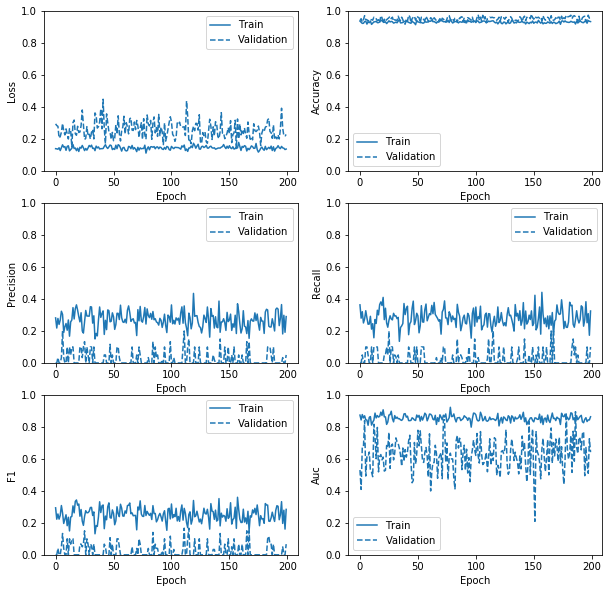

In [29]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [ ]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [ ]:
# print("Time taken:",end-start)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [ ]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [ ]:
# print("Time taken:",end-start)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [30]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 20s 199ms/step


In [31]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.238 :   0.182
Accuracy : 0.933 :   0.959
Precision : 0.070 :   0.055
Recall : 0.074 :   0.047
F1 : 0.063 :   0.047
AUC : 0.656 :   0.593


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [32]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1227.0828902721405, 195.63138055801392)

In [ ]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [ ]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [33]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

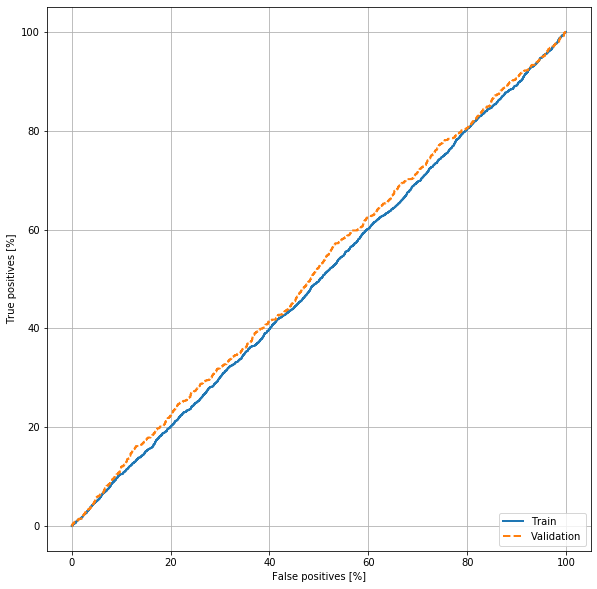

In [34]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 94420 
FP: 5035 
FN: 2259 
TP: 120
Healthy Patients - correctly identified (True Negatives):  94420 0.9493740887838721
Healthy Patients - predicted to have glaucoma (False Positives):  5035 0.050625911216127896
Glaucoma Patients - predicted healthy (False Negatives):  2259 0.9495586380832283
Glaucoma Patients - correctly identified (True Positives):  120 0.05044136191677175

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


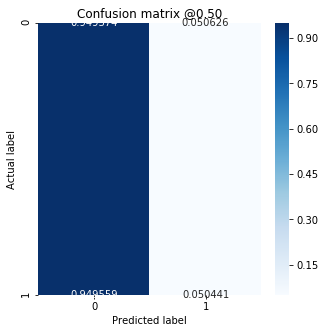

In [35]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 32472 
FP: 662 
FN: 797 
TP: 12
Healthy Patients - correctly identified (True Negatives):  32472 0.9800205227259009
Healthy Patients - predicted to have glaucoma (False Positives):  662 0.019979477274099114
Glaucoma Patients - predicted healthy (False Negatives):  797 0.9851668726823238
Glaucoma Patients - correctly identified (True Positives):  12 0.014833127317676144

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


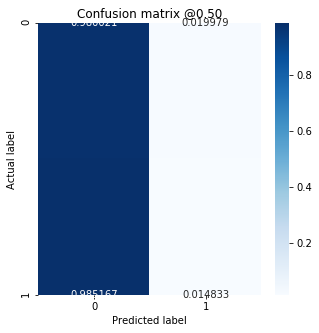

In [36]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [ ]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 78 tr layers and cw 0.5:1.5 and 0.3:1.8"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [ ]:
# client = MlflowClient()
# run = client.create_run('19')
# client.set_tag(run.info.run_id, "tag_key", tag_value)